In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Import the pandas library
import pandas as pd

file_name = "month_data.csv"
# Define the file path
file_path = r"../" +"data" + "/" + file_name

# Load the CSV file into a DataFrame
df = pd.read_csv(file_path, sep=';', encoding='utf-8')

# Display the first few rows of the DataFrame
#print(df.head())

In [3]:
import numpy as np

specific_date = '2019-03-27'  # Change this to desired date
start_time = '7:00:00' 
end_time = '19:00:00'

filtered_for_date=df[(df['Datum_PAU']== specific_date)].copy()
filtered_for_date['PlanAnkTid'] = pd.to_datetime(filtered_for_date['PlanAnkTid'],errors='coerce')
filtered_for_date['PlanAvgTid'] = pd.to_datetime(filtered_for_date['PlanAvgTid'],errors='coerce')

filtered_for_date = filtered_for_date[((filtered_for_date['PlanAnkTid'].dt.time >= pd.to_datetime(start_time).time()) &
                                      (filtered_for_date['PlanAnkTid'].dt.time <= pd.to_datetime(end_time).time())) | 
                                      ((filtered_for_date['PlanAvgTid'].dt.time >= pd.to_datetime(start_time).time()) &
                                      (filtered_for_date['PlanAvgTid'].dt.time <= pd.to_datetime(end_time).time()))]
filtered_for_platform= filtered_for_date[(filtered_for_date['Ankomstplats']=='Uppsala c') | ( filtered_for_date['Avgångsplats']=='Uppsala c' )]
unique_missions = filtered_for_platform['Tåguppdrag'].unique()
filtered_missions = filtered_for_platform[filtered_for_platform['Tåguppdrag'].isin(unique_missions)]
output = filtered_missions[['Tåguppdrag' , 'Förstaplatssignatur_för_Uppdrag' , 'Sistaplatssignatur_för_Uppdrag']]
output.head(30)

output_file_path= 'filtered_mission_output.xlsx'
#output.to_excel(output_file_path, index=False)

In [4]:

import pandas as pd
# List of specific mission types interested in
mission_types = [17, 19, 271, 8201, 8416, 8420, 20, 14, 22, 64, 280, 8412, 8440]

# Initialize a dictionary to hold routes for each mission
all_routes = {}
all_filtered_rows = []  # List to store rows used to generate the routes

# Loop through each mission type
for mission_type in mission_types:
    # Initialize a list to hold the routes for the current mission
    routes = []

    # Step 4: Iterate through the DataFrame to build routes
    for index, row in filtered_for_date.iterrows():
        if row['UppehållstypAvgång'] == 'Första' and row['Tåguppdrag'] == mission_type:
            # Start the route with the departure station
            current_route = [row['Avgångsplats']]
            all_filtered_rows.append(row)  # Save the current row to the list
            next_row = row

            # Continue to add stations until reaching 'Sista'
            while next_row['UppehållstypAnkomst'] != 'Sista':
                # Find the next station in the DataFrame that matches the current departure station
                next_station = filtered_for_date[(filtered_for_date['Avgångsplats'] == next_row['Ankomstplats']) &
                                  (filtered_for_date['Tåguppdrag'] == mission_type)]

                if not next_station.empty:
                    current_route.append(next_station.iloc[0]['Ankomstplats'])
                    all_filtered_rows.append(next_station.iloc[0])  # Save the row to the list
                    next_row = next_station.iloc[0]  # Move to the next row
                else:
                    break  # Exit if no further stations are found

            # If the last station is 'Sista', append it to the route
            if next_row['UppehållstypAnkomst'] == 'Sista':
                current_route.append(next_row['Ankomstplats'])

            # Add the complete route to the routes list
            routes.append(" -> ".join(current_route))

    # Store the routes for the current mission in the dictionary
    all_routes[mission_type] = routes

# Save the filtered rows used to generate the routes into a new DataFrame
filtered_rows_df = pd.DataFrame(all_filtered_rows)



In [5]:
import preprocessing

In [6]:

preprocessing.create_ids(filtered_rows_df)
preprocessing.missing_utfAvgTid(filtered_rows_df)




------Missing values filled------
total missing values in UtfAvgTid 11
total missing values in UtfAnkTid 0
after update total nan avg values are  0
after update total nan ank values are  0






In [7]:


# Save the DataFrame to a CSV file
output_rows_file_name = 'test_network_week_45_bigger.csv'
filtered_rows_df.to_csv('../data/' + output_rows_file_name, index=False, encoding='utf-8-sig')



# Display the routes for each mission
for mission, routes in all_routes.items():
    print(f"\nRoutes for {mission}:")
    for route in routes:
        print("Route:", route)

# Notify the user where the rows have been saved
print(f"\nThe rows used to generate the routes have been saved to {output_rows_file_name}")




Routes for 17:
Route: Falun -> Ornäs -> Borlänge c -> Stora Tuna -> Gustafs -> Säter -> Vikmanshyttan -> Hedemora -> Snickarbo -> Avesta Centrum -> Avesta Krylbo -> Rosshyttan -> Broddbo -> Sala -> Isätra -> Heby -> Morgongåva -> Järlåsa -> Brunna -> Uppsala norra -> Uppsala c -> Säby -> Ekeby -> Knivsta -> Myrbacken -> Arlanda Central -> Arlanda nedre -> Blackvreten -> Skavstaby -> Upplands Väsby -> Rotebro -> Norrviken -> Häggvik -> Sollentuna -> Kummelby -> Helenelund -> Ulriksdal -> Solna -> Tomteboda övre -> Karlberg -> Stockholm C -> Stockholm C

Routes for 19:
Route: Falun -> Ornäs -> Borlänge c -> Stora Tuna -> Gustafs -> Säter -> Vikmanshyttan -> Hedemora -> Snickarbo -> Avesta Centrum -> Avesta Krylbo -> Rosshyttan -> Broddbo -> Sala -> Isätra -> Heby -> Morgongåva -> Järlåsa -> Brunna -> Uppsala norra -> Uppsala c -> Säby -> Ekeby -> Knivsta -> Myrbacken -> Arlanda Central -> Arlanda nedre -> Blackvreten -> Skavstaby -> Upplands Väsby -> Rotebro -> Norrviken -> Häggvik -> S

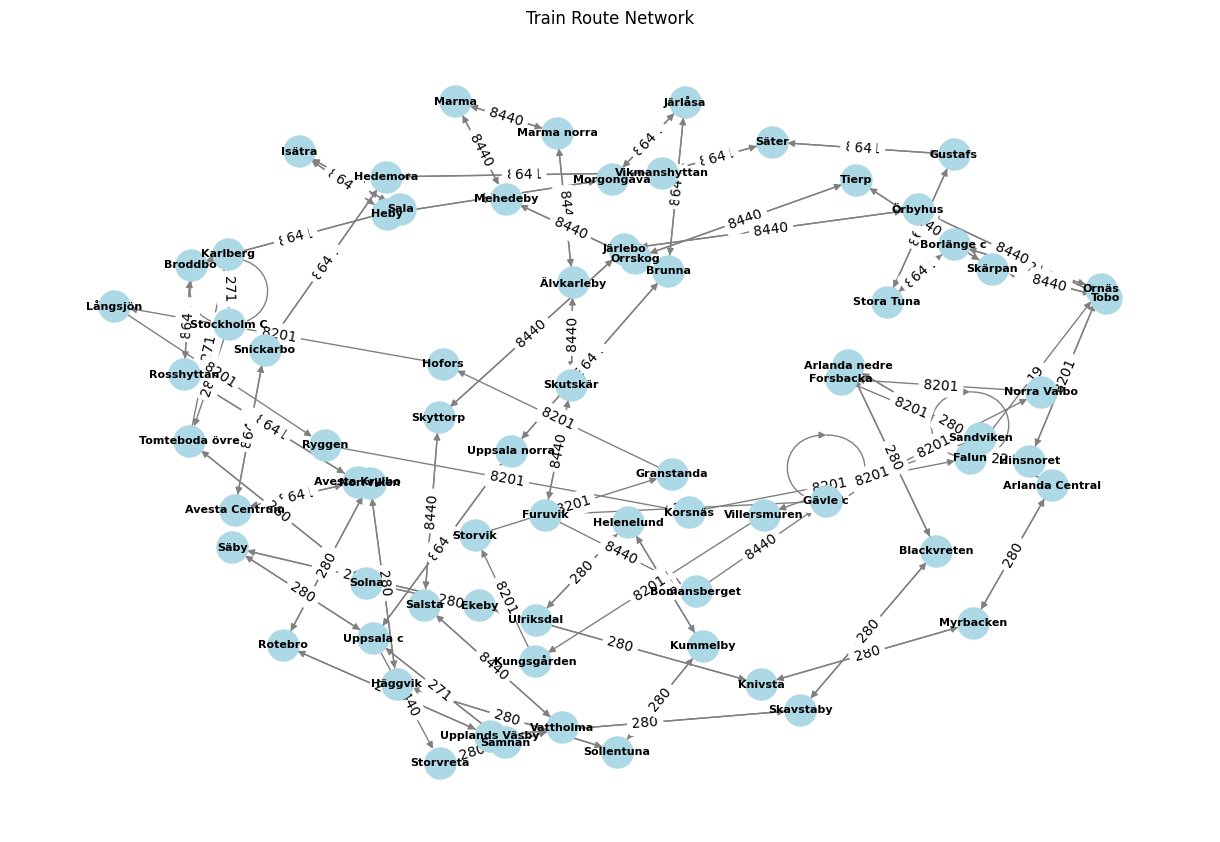

In [8]:
import networkx as nx

G = nx.DiGraph()

# Add edges for each route
for mission, routes in all_routes.items():
    for route in routes:
        stations = route.split(" -> ")
        for i in range(len(stations) - 1):
            G.add_edge(stations[i], stations[i + 1], mission=mission)

# Draw the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=0.5)  # positions for all nodes
nx.draw(G, pos, with_labels=True, node_size=500, node_color="lightblue", font_size=8, font_weight="bold", edge_color="gray", arrows=True)

# Show edge labels for mission types
edge_labels = nx.get_edge_attributes(G, 'mission')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.title("Train Route Network")
plt.show()
